# Data og features 

In [121]:
# celle 1: imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from pathlib import Path

#sklearn = gud 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from scipy import stats

from collections import Counter

RANDOM_STATE = 42


In [122]:
# celle 2: data 
data = pd.read_csv("/Users/chrisbang/Desktop/DTU/januar projekt /data/måske? /new output fil /all_songs.csv")

print("Raw shape:", data.shape)  # <-- print FØR cleaning

data = data[~data["track_genre"].isin(["other"])].reset_index(drop=True)  # excludere others

print("After cleaning shape:", data.shape)  # <-- print EFTER cleaning
print("Genres (top 10):")
print(data["track_genre"].value_counts().head(10))

Raw shape: (114000, 21)
After cleaning shape: (70000, 21)
Genres (top 10):
track_genre
rock          23000
electronic    18000
pop           12000
jazz_soul      9000
roots          5000
hiphop         3000
Name: count, dtype: int64


In [123]:
# celle 2: mini batch for hastighed og gennemtjekkelse 
'''
DEBUG_N = 2000

data = pd.read_csv("/Users/chrisbang/Desktop/DTU/januar projekt /data/måske? /new output fil /all_songs.csv")
data = data[~data["track_genre"].isin(["other"])].reset_index(drop=True)

data = data.sample(n=min(DEBUG_N, len(data)), random_state=RANDOM_STATE).reset_index(drop=True)

print("After mini-batch shape:", data.shape)
print(data["track_genre"].value_counts().head(10))
'''

'\nDEBUG_N = 2000\n\ndata = pd.read_csv("/Users/chrisbang/Desktop/DTU/januar projekt /data/måske? /new output fil /all_songs.csv")\ndata = data[~data["track_genre"].isin(["other"])].reset_index(drop=True)\n\ndata = data.sample(n=min(DEBUG_N, len(data)), random_state=RANDOM_STATE).reset_index(drop=True)\n\nprint("After mini-batch shape:", data.shape)\nprint(data["track_genre"].value_counts().head(10))\n'

In [124]:
# celle 3: definere de features vi kigger på
features = [
    "energy",
    "danceability",
    "loudness",
    "acousticness",
    "speechiness",
    "valence",
    "instrumentalness",
    "tempo",
    "duration_ms",
    "popularity",
    "explicit",
    "key",
    "mode",
    "time_signature",
]

# tjekker om jeg mangler nogen celler 
missing = set(features) - set(data.columns)
assert not missing, f"Mangler kolonner: {missing}"

X = data[features].to_numpy()

le = LabelEncoder()
y = le.fit_transform(data["track_genre"])

print("X:", X.shape, "y:", y.shape, "classes:", len(le.classes_))
print("Classes:", list(le.classes_))
print("Class counts:", np.bincount(y))

# split test og træning 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

X: (70000, 14) y: (70000,) classes: 6
Classes: ['electronic', 'hiphop', 'jazz_soul', 'pop', 'rock', 'roots']
Class counts: [18000  3000  9000 12000 23000  5000]
Train: (56000, 14) Test: (14000, 14)


# Linear vs. RBF

### Liear SVM 


In [125]:
# celle 4: Den lineær model 
linear_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearSVC(
        C=1.0,
        class_weight="balanced",
        dual=False,
        max_iter=20000,
        random_state=RANDOM_STATE
    ))
])

linear_model.fit(X_train, y_train)
y_pred_lin = linear_model.predict(X_test)

acc_lin = accuracy_score(y_test, y_pred_lin)
f1_lin  = f1_score(y_test, y_pred_lin, average="macro", zero_division = 0 )

print("LinearSVC: per-genre metrics")
print(
    classification_report(
        y_test,
        y_pred_lin,
        target_names=le.classes_,
        digits=3,
        zero_division=0
    )
)


LinearSVC: per-genre metrics
              precision    recall  f1-score   support

  electronic      0.598     0.637     0.617      3600
      hiphop      0.120     0.073     0.091       600
   jazz_soul      0.292     0.178     0.221      1800
         pop      0.392     0.255     0.309      2400
        rock      0.592     0.632     0.612      4600
       roots      0.246     0.550     0.340      1000

    accuracy                          0.481     14000
   macro avg      0.374     0.388     0.365     14000
weighted avg      0.476     0.481     0.469     14000



### RBF model 

In [126]:
# celle 5: rbf modellen 
rbf_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced",
        cache_size=2000
    ))
])

rbf_model.fit(X_train, y_train)
y_pred_rbf = rbf_model.predict(X_test)

acc_rbf = accuracy_score(y_test, y_pred_rbf)
f1_rbf  = f1_score(y_test, y_pred_rbf, average="macro", zero_division = 0 )

print("RBF - SVC:")
print(
    classification_report(
        y_test,
        y_pred_rbf,
        target_names=le.classes_,
        digits=3,
        zero_division=0
    )
)

RBF - SVC:
              precision    recall  f1-score   support

  electronic      0.746     0.618     0.676      3600
      hiphop      0.175     0.433     0.249       600
   jazz_soul      0.508     0.443     0.473      1800
         pop      0.455     0.365     0.405      2400
        rock      0.734     0.584     0.651      4600
       roots      0.288     0.683     0.405      1000

    accuracy                          0.538     14000
   macro avg      0.484     0.521     0.477     14000
weighted avg      0.604     0.538     0.557     14000



#### Over samplings modellen 

In [ ]:
# celle 6: over sampling 
counts = Counter(y_train)
max_c = max(counts.values())
target = int(0.5 * max_c)

sampling_dict = {cls: (cnt if cnt > target else target) for cls, cnt in counts.items()}

print("Before:", counts)
print("Target after SMOTE:", sampling_dict)

smote_rbf_model = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(
        random_state=RANDOM_STATE,
        k_neighbors=3,
        sampling_strategy=sampling_dict
    )),
    ("model", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

smote_rbf_model.fit(X_train, y_train)
y_pred_smote = smote_rbf_model.predict(X_test)

acc_smote = accuracy_score(y_test, y_pred_smote)
f1_smote  = f1_score(y_test, y_pred_smote, average="macro", zero_division=0)

print("\nOver sampling versionen")
print("ACC:", round(acc_smote, 4))
print("macro-F1:", round(f1_smote, 4))
print(classification_report(
        y_test,
        y_pred_smote,
        target_names=le.classes_,
        digits=3,
        zero_division=0
    ))


Before: Counter({np.int64(4): 18400, np.int64(0): 14400, np.int64(3): 9600, np.int64(2): 7200, np.int64(5): 4000, np.int64(1): 2400})
Target after SMOTE: {np.int64(5): 9200, np.int64(1): 9200, np.int64(0): 14400, np.int64(4): 18400, np.int64(3): 9600, np.int64(2): 9200}

Overfitting versionen
ACC: 0.5749
macro-F1: 0.485
              precision    recall  f1-score   support

  electronic      0.714     0.674     0.693      3600
      hiphop      0.186     0.338     0.240       600
   jazz_soul      0.552     0.423     0.479      1800
         pop      0.545     0.280     0.370      2400
        rock      0.655     0.739     0.694      4600
       roots      0.344     0.585     0.433      1000

    accuracy                          0.575     14000
   macro avg      0.499     0.507     0.485     14000
weighted avg      0.596     0.575     0.573     14000



## Confusion matrix

<Figure size 600x500 with 0 Axes>

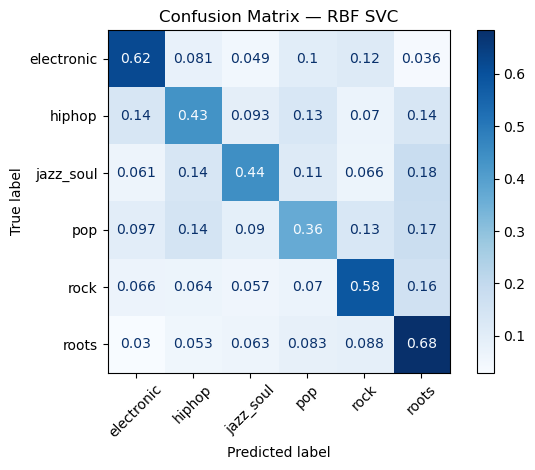

In [128]:
# celle 7:: confusion matrix 
plt.figure(figsize=(6, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_rbf,
    display_labels=le.classes_,
    xticks_rotation=45,
    normalize = "true", # vælger at normalisere 
    cmap="Blues"
)

plt.title("Confusion Matrix — RBF SVC")
plt.tight_layout()
plt.show()



## Permutation importance med RBF

In [129]:
# celle 8: feature valg 
rng = np.random.default_rng(RANDOM_STATE)
n_eval = min(1000, len(X_test))
idx = rng.choice(len(X_test), size=n_eval, replace=False)

X_eval = X_test[idx]
y_eval = y_test[idx]

# Permutation importance
r = permutation_importance(
    rbf_model,          # hele pipeline (scaler + model)
    X_eval, y_eval,
    n_repeats=3,        # lavt → forstå flow først
    scoring="f1_macro",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

importances = r.importances_mean
std = r.importances_std

# Sortér features efter importance
ranking = sorted(
    zip(features, importances, std),
    key=lambda x: x[1],
    reverse=True
)

print("Feature importance (RBF, permutation):")
for f, imp, s in ranking:
    print(f"{f:18s}  ΔF1 = {imp: .4f} ± {s: .4f}")

Feature importance (RBF, permutation):
danceability        ΔF1 =  0.1012 ±  0.0125
energy              ΔF1 =  0.0817 ±  0.0109
popularity          ΔF1 =  0.0813 ±  0.0128
valence             ΔF1 =  0.0738 ±  0.0074
acousticness        ΔF1 =  0.0732 ±  0.0123
instrumentalness    ΔF1 =  0.0504 ±  0.0058
tempo               ΔF1 =  0.0424 ±  0.0021
speechiness         ΔF1 =  0.0409 ±  0.0052
loudness            ΔF1 =  0.0386 ±  0.0134
duration_ms         ΔF1 =  0.0385 ±  0.0031
mode                ΔF1 =  0.0235 ±  0.0031
explicit            ΔF1 =  0.0205 ±  0.0083
key                 ΔF1 =  0.0057 ±  0.0059
time_signature      ΔF1 =  0.0057 ±  0.0010


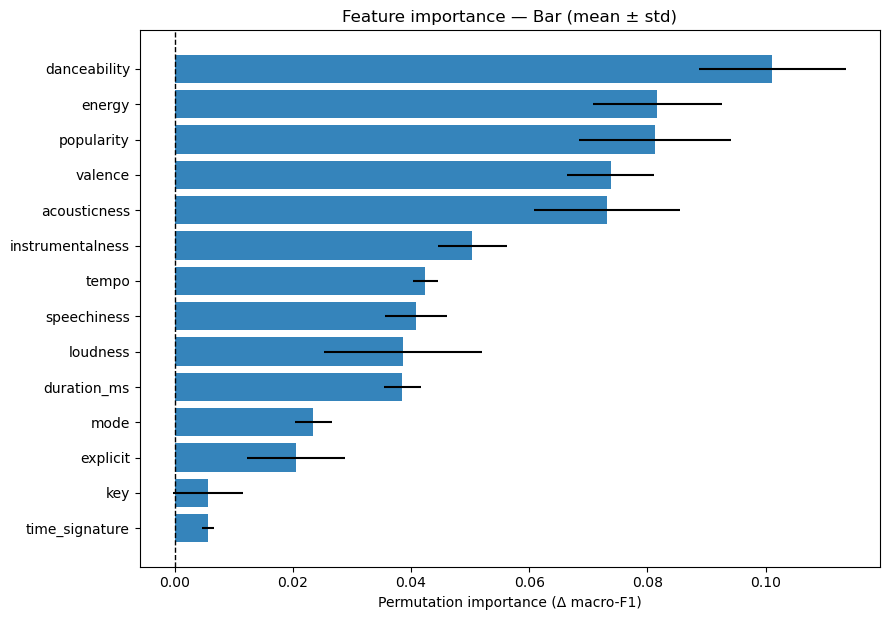

In [130]:
# celle 9: en mega flot graf 
importances_mean = r.importances_mean
importances_std  = r.importances_std
importances_all  = r.importances      # shape: (n_features, n_repeats)

# Sortér efter mean importance
order = np.argsort(importances_mean)[::-1]
feat_sorted = np.array(features)[order]
mean_sorted = importances_mean[order]
std_sorted  = importances_std[order]
all_sorted  = importances_all[order]

plt.figure(figsize=(9, 0.45 * len(features)))
plt.barh(feat_sorted[::-1], mean_sorted[::-1], xerr=std_sorted[::-1], alpha=0.9)
plt.axvline(0, color = "black", linewidth=1, linestyle = "--")
plt.xlabel("Permutation importance (Δ macro-F1)")
plt.title("Feature importance — Bar (mean ± std)")
plt.tight_layout()
plt.show()



#### tager top-k features

In [131]:
#celle 10: vælg top-k features
selected_features = [f for f, imp, _ in ranking if imp > 0]
print("Selected features:", selected_features)
print("k =", len(selected_features))

# find kolonne-indekser for de valgte features i din oprindelige features-liste
feat_to_idx = {f: i for i, f in enumerate(features)}
sel_idx = [feat_to_idx[f] for f in selected_features]

X_train_sel = X_train[:, sel_idx]
X_test_sel  = X_test[:, sel_idx]

rbf_sel = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced",
        cache_size=2000
    ))
])

rbf_sel.fit(X_train_sel, y_train)
y_pred_rbf_sel = rbf_sel.predict(X_test_sel)

print("\nRBF SVC (selected features: imp > 0)")
print("ACC:", round(accuracy_score(y_test, y_pred_rbf_sel), 4))
print("macro-F1:", round(f1_score(y_test, y_pred_rbf_sel, average="macro", zero_division=0), 4))

Selected features: ['danceability', 'energy', 'popularity', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'speechiness', 'loudness', 'duration_ms', 'mode', 'explicit', 'key', 'time_signature']
k = 14

RBF SVC (selected features: imp > 0)
ACC: 0.5379
macro-F1: 0.4766


## Flotte grafer 


##### Confusion matrix 

<Figure size 700x600 with 0 Axes>

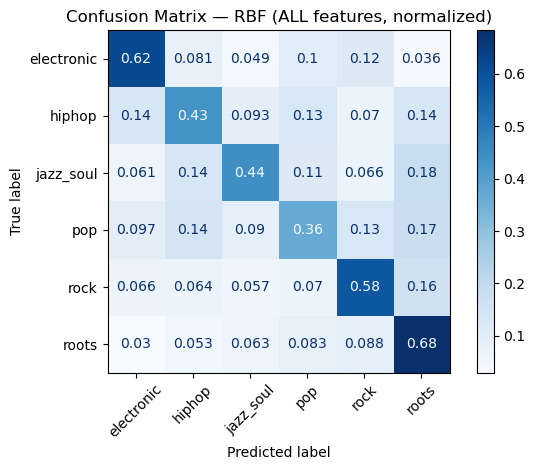

In [133]:
# celle 11: RBF på ALL features 
rbf_all = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced",
        cache_size=2000
    ))
])

rbf_all.fit(X_train, y_train)
y_pred_all = rbf_all.predict(X_test)

plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_all,
    display_labels=le.classes_,
    xticks_rotation=45,
    normalize="true",
    cmap="Blues"
)
plt.title("Confusion Matrix — RBF (ALL features, normalized)")
plt.tight_layout()
plt.show()


<Figure size 700x600 with 0 Axes>

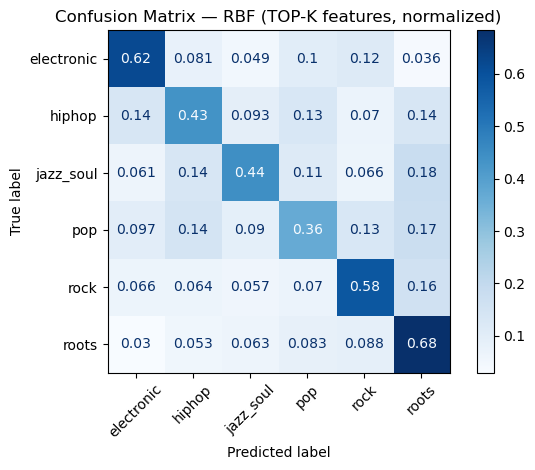

In [134]:
# celle 12: top - k features 
feat_to_idx = {f: i for i, f in enumerate(features)}
sel_idx = [feat_to_idx[f] for f in selected_features]

X_train_sel = X_train[:, sel_idx]
X_test_sel  = X_test[:, sel_idx]

rbf_topk = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced",
        cache_size=2000
    ))
])

rbf_topk.fit(X_train_sel, y_train)
y_pred_topk = rbf_topk.predict(X_test_sel)

plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_topk,
    display_labels=le.classes_,
    xticks_rotation=45,
    normalize="true",
    cmap="Blues"
)
plt.title("Confusion Matrix — RBF (TOP-K features, normalized)")
plt.tight_layout()
plt.show()


#### PCA plot for RBF

In [135]:
# celle 13: funktionen 
def pca_plot(
    X_train, y_train, X_test, y_test,
    class_names, title,
    random_state=42, grid_step=0.03
):
    # ----- Scale + PCA (fit på train) -----
    scaler = StandardScaler().fit(X_train)
    Xtr_s = scaler.transform(X_train)
    Xte_s = scaler.transform(X_test)

    pca = PCA(n_components=2, random_state=random_state).fit(Xtr_s)
    Xtr_2d = pca.transform(Xtr_s)
    Xte_2d = pca.transform(Xte_s)

    # ----- Model i PCA-rummet (kun visualisering) -----
    model_2d = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced"))
    ])
    model_2d.fit(Xtr_2d, y_train)

    # ----- Meshgrid -----
    x_min, x_max = Xte_2d[:, 0].min() - 1, Xte_2d[:, 0].max() + 1
    y_min, y_max = Xte_2d[:, 1].min() - 1, Xte_2d[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, grid_step),
        np.arange(y_min, y_max, grid_step)
    )

    Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    n_classes = len(class_names)
    bg_cmap = ListedColormap(plt.cm.tab10.colors[:n_classes])
    pt_cmap = plt.cm.get_cmap("tab10", n_classes)

    # ----- Predict i PCA-rum (matcher baggrund) -----
    y_pred = model_2d.predict(Xte_2d)

    # ----- Plot -----
    plt.figure(figsize=(9, 7))
    plt.contourf(xx, yy, Z, alpha=0.18, cmap=bg_cmap)

    for i, name in enumerate(class_names):
        mask = (y_pred == i)
        plt.scatter(
            Xte_2d[mask, 0], Xte_2d[mask, 1],
            s=35, alpha=0.85, label=name,
            color=pt_cmap(i),
            edgecolors="white", linewidths=0.4
        )

    wrong = (y_pred != y_test)
    if wrong.any():
        plt.scatter(
            Xte_2d[wrong, 0], Xte_2d[wrong, 1],
            s=90, marker="x", linewidths=2,
            color="black", label="Misclassified"
        )

    plt.title(title, fontsize=14)
    plt.xlabel("PC1", fontsize=11)
    plt.ylabel("PC2", fontsize=11)
    plt.legend(ncol=2, fontsize=9, frameon=True)
    plt.grid(alpha=0.15)
    plt.tight_layout()
    plt.show()


In [ ]:
# celle 14: alle features 
rbf_all = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced",
        cache_size=2000
    ))
])

rbf_all.fit(X_train, y_train)
y_pred_all = rbf_all.predict(X_test)

pca_plot(
    X_train, y_train,
    X_test, y_test,
    class_names=le.classes_,
    title="PCA decision regions (2D) — RBF (ALL features)",
    random_state=RANDOM_STATE
)



/var/folders/hq/hw1yj1nn4_qcz03fyflbvy6c0000gn/T/ipykernel_15811/2667847562.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  pt_cmap = plt.cm.get_cmap("tab10", n_classes)


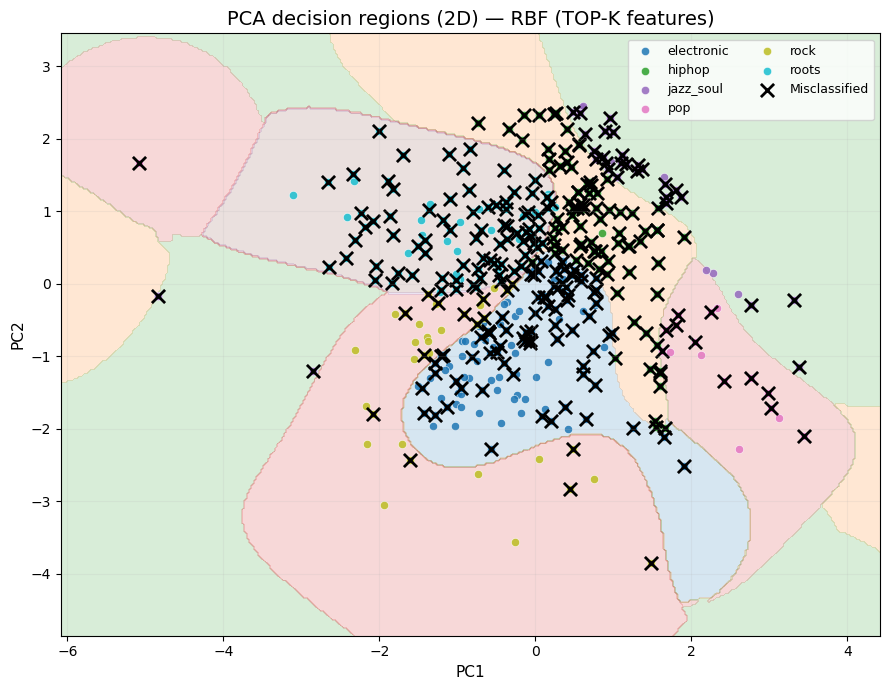

In [ ]:
# celle 15: 
feat_to_idx = {f: i for i, f in enumerate(features)}
sel_idx = [feat_to_idx[f] for f in selected_features]

X_train_sel = X_train[:, sel_idx]
X_test_sel  = X_test[:, sel_idx]

rbf_topk = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced",
        cache_size=2000
    ))
])

rbf_topk.fit(X_train_sel, y_train)
y_pred_topk = rbf_topk.predict(X_test_sel)

pca_plot(
    X_train_sel, y_train,
    X_test_sel, y_test,
    class_names=le.classes_,
    title="PCA decision regions (2D) — RBF (TOP-K features)",
    random_state=RANDOM_STATE
)